In [ ]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import torch
import numpy as np

from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

- `T`: number of points in the training data
- `n`: dimension of the training data (number of features)
- `S`: sparsity (probability that $x_i$ is 0)

In [ ]:
def generate_dataset(T: int, n: int, S: float) -> torch.Tensor:
    assert 0 <= S <= 1, "Sparsity must be between 0 and 1"

    dataset = torch.rand(T, n)
    mask_threshold = torch.rand(T, n)
    mask = mask_threshold < S
    dataset[mask] = 0

    norms = torch.norm(dataset, p=2, dim=1, keepdim=True)
    dataset = torch.where(norms > 0, dataset / norms, dataset)
    return dataset

- `n`: input dimension
- `m`: hidden dimension

In [ ]:
class ToyModel(nn.Module):
    def __init__(self, n: int, m: int):
        super().__init__()
        self.hidden = nn.Linear(n, m)
        self.relu = nn.ReLU()
        self.output = nn.Linear(m, n)

        nn.init.xavier_uniform_(self.hidden.weight)
        nn.init.xavier_uniform_(self.output.weight)
        nn.init.zeros_(self.hidden.bias)
        nn.init.zeros_(self.output.bias)

    def forward(self, x):
        h = self.hidden(x)
        h = self.relu(h)
        logits = self.output(h)
        return logits

In [ ]:
def generate_dataset_and_train_toy_model(T: int, n: int, S: float, m: int) -> tuple[torch.Tensor, ToyModel]:

    # Setup learning params
    batch_size = T  # full batch
    num_updates = 50000  # epochs
    warmup_steps = 2500

    learning_rate = 1e-3
    weight_decay = 1e-2

    def lr_lambda(current_step: int):
        if current_step < warmup_steps:
            return current_step / warmup_steps
        else:
            return 1.0


    # Create data and model
    loss_fn = nn.MSELoss()
    model = ToyModel(n, m).to(device)
    dataset = generate_dataset(T, n, S).to(device)
    optimizer = AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)


    run = wandb.init(
        project="toy-superposition",
        config={
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "warmup_steps": warmup_steps,
            "batch_size": batch_size,
            "epochs": num_updates,
            "T": T,
            "n": n,
            "S": S,
            "m": m,
        },
    )


    # Train the model
    inputs = dataset
    for step in range(num_updates):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, inputs)

        loss.backward()
        optimizer.step()
        scheduler.step()

        wandb.log({"loss": loss})


    # Provide the generated dataset and model
    return dataset, model

In [ ]:
import matplotlib.pyplot as plt

def plot_vectors(displayed_vectors, title):
    plt.figure(figsize=(4, 4))
    origin = [0], [0]

    x_values = [vector[0] for vector in displayed_vectors]
    y_values = [vector[1] for vector in displayed_vectors]
    x_min, x_max = min(x_values), max(x_values)
    y_min, y_max = min(y_values), max(y_values)
    overall_max = max(abs(x_min), abs(x_max), abs(y_min), abs(y_max))

    for vector in displayed_vectors:
        plt.quiver(*origin, vector[0], vector[1], angles='xy', scale_units='xy', scale=1, color="b", alpha=0.6)

    plt.xlim(-overall_max, overall_max)
    plt.ylim(-overall_max, overall_max)
    plt.title(title)
    plt.grid()
    plt.axhline(0, color='grey', lw=0.5)
    plt.axvline(0, color='grey', lw=0.5)

    plt.show()

In [ ]:
T = 50000
n = 10000
S = 0.999
m = 2

dataset, model = generate_dataset_and_train_toy_model(T, n, S, m)

loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,7e-05


Step 0/50000, Loss: 0.00010003703937400132
Step 1000/50000, Loss: 9.991992556024343e-05
Step 2000/50000, Loss: 9.991961997002363e-05
Step 3000/50000, Loss: 9.991879051085562e-05
Step 4000/50000, Loss: 9.991391561925411e-05
Step 5000/50000, Loss: 9.989814134314656e-05
Step 6000/50000, Loss: 9.988839883590117e-05
Step 7000/50000, Loss: 9.988406236516312e-05
Step 8000/50000, Loss: 9.9881952337455e-05
Step 9000/50000, Loss: 9.988078090827912e-05
Step 10000/50000, Loss: 9.988004603656009e-05
Step 11000/50000, Loss: 9.987951489165425e-05
Step 12000/50000, Loss: 9.987910743802786e-05
Step 13000/50000, Loss: 9.98787727439776e-05
Step 14000/50000, Loss: 9.98785108095035e-05
Step 15000/50000, Loss: 9.987827797885984e-05
Step 16000/50000, Loss: 9.987807425204664e-05
Step 17000/50000, Loss: 9.987789235310629e-05
Step 18000/50000, Loss: 9.987773228203878e-05
Step 19000/50000, Loss: 9.987757948692888e-05
Step 20000/50000, Loss: 9.987744851969182e-05
Step 21000/50000, Loss: 9.987731755245477e-05
Step

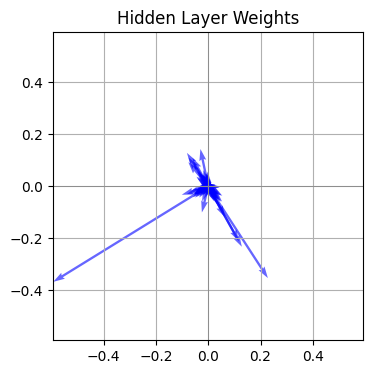

In [ ]:
weight_vector = model.hidden.weight.detach().cpu().numpy()
plot_vectors(weight_vector.T, title="Hidden Layer Weights")

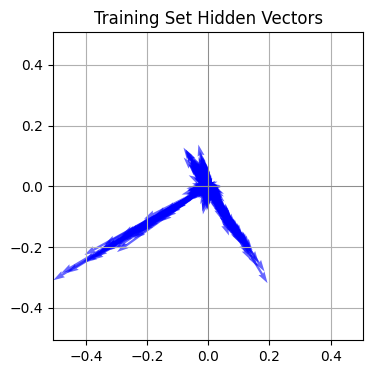

In [ ]:
X = dataset.cpu().numpy()
training_set_hidden_vectors = (X @ weight_vector.T)
plot_vectors(training_set_hidden_vectors, title="Training Set Hidden Vectors")